In [10]:
import nltk
import pandas as pd
import numpy as np


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, recall_score, 
                             precision_score, f1_score, matthews_corrcoef, 
                             ConfusionMatrixDisplay, classification_report, confusion_matrix)
from scipy.spatial.distance import cosine
from typing import Callable, Sequence

# Detecting Spam Or Ham with Bag of words

In [3]:
df = pd.read_csv("emails.csv")
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)

In [69]:
class Model:
    def __init__(self, 
                 encoder,
                 estimator = KNeighborsClassifier(),
                ):
        self.encoder = encoder
        self.estimator=estimator
    
    def get_vocabulary(self, all_docs)->set:
        vocab = set()
        for doc in all_docs:
            for word in nltk.word_tokenize(doc):
                vocab|={word.lower()}
        return vocab
    
    def fit(self, X, y):
        X, y = X.to_numpy(), y.to_numpy()
        self.vocab = self.get_vocabulary(X)
        
        X = list(map(lambda x: self.encoder(x, self.vocab), X))
        
        self.X = X
        self.y = y
        self.estimator.fit(X,y)
        return self
    
    def predict(self, X):
        X = X.to_numpy()
        X = list(map(lambda x: self.encoder(x, self.vocab), X))
        return self.estimator.predict(X)

In [92]:
class Model2:
    def __init__(self, 
                 encoder,
                 estimator = KNeighborsClassifier(),
                ):
        self.encoder = encoder
        self.estimator=estimator
    
    def get_vocabulary_and_frequency(self, all_docs)->set:
        vocab = dict()
        for doc in all_docs:
            current_words = dict()
            for word in nltk.word_tokenize(doc):
                try:
                    current_words[word.lower()]
                except:
                    vocab[ word.lower() ] = vocab.get(word.lower(),  0) + 1
                    current_words[ word.lower() ] = 1
        return list(vocab.keys()), list(vocab.values())
    
    def fit(self, X, y):
        X, y = X.to_numpy(), y.to_numpy()
        self.vocab, self.doc_freq = self.get_vocabulary_and_frequency(X)
        
        X = list(map(lambda x: self.encoder(x, self.doc_freq, self.vocab), X))
        
        self.X = X
        self.y = y
        self.estimator.fit(X,y)
        return self
    
    def predict(self, X):
        X = X.to_numpy()
        X = list(map(lambda x: self.encoder(x, self.doc_freq, self.vocab), X))
        return self.estimator.predict(X)

In [47]:
def term_existence(document: str, vocab: list):
    bow = np.zeros(len(vocab))
    loc = dict(map(lambda pair: (pair[1], pair[0]), enumerate(vocab)))
    
    for word in nltk.word_tokenize(document):
        try:
            bow[loc[word.lower()]]=1
        except:
            continue
        
    return list(bow)

In [12]:
def term_weighting(document: str, vocab: list):
    bow = np.zeros(len(vocab))
    loc = dict(map(lambda pair: (pair[1], pair[0]), enumerate(vocab)))
    
    for word in nltk.word_tokenize(document):
        try:
            bow[loc[word.lower()]]+=1
        except:
            continue
    return bow

In [83]:
def term_freq(
        document: str, 
        vocab: list, 
        t = lambda x: np.log2(x+1)
    ):
    bow = np.zeros(len(vocab))
    loc = dict(map(lambda pair: (pair[1], pair[0]), enumerate(vocab)))
    
    for word in nltk.word_tokenize(document):
        try:
            bow[loc[word.lower()]]+=1
        except:
            continue
    return t(bow)

In [89]:
def inv_term_freq(document: str, 
                  doc_freq: list, 
                  vocab: list, 
                  t=lambda x: np.log2(x+1)):
    bow = np.zeros(len(vocab))
    loc = dict(map(lambda pair: (pair[1], pair[0]), enumerate(vocab)))
    
    for word in nltk.word_tokenize(document):
        try:
            bow[loc[word.lower()]]+=1
        except:
            continue
    bow = t(bow)
    
    for i, v in enumerate(bow):
        if v!=0:
            bow[i] = np.log((doc_freq[i] + 1) / bow[i])
    return bow

In [19]:
train_set.head()

,Text,Spam
4518,"Subject: rice cfos conference christie , thi...",0
4472,Subject: sfa licenses iris : i forwarded the...,0
799,Subject: reading to children has proven to inc...,1
4809,Subject: re : telephone interview with enron c...,0
1043,"Subject: harderr hello , welcome to medzon vi...",1


In [64]:
X_train = train_set.Text
y_train = train_set.Spam

In [67]:
xx_train, xx_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

## Term Existence Model

In [70]:
m_exist = Model(term_existence).fit(xx_train, yy_train)

In [72]:
preds = m_exist.predict(xx_test)

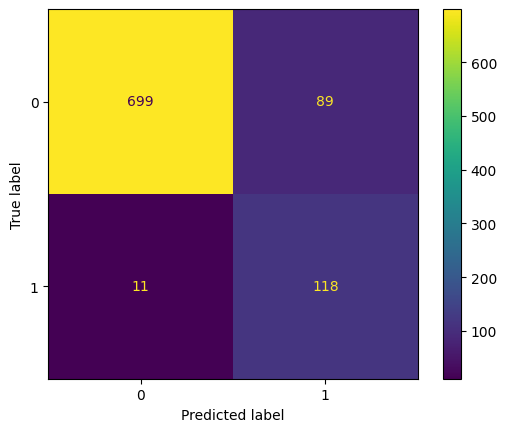

In [74]:
ConfusionMatrixDisplay(
    confusion_matrix(preds, yy_test)
).plot()

In [76]:
print(classification_report(preds, yy_test))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       788
           1       0.57      0.91      0.70       129

    accuracy                           0.89       917
   macro avg       0.78      0.90      0.82       917
weighted avg       0.93      0.89      0.90       917



## Term Weighting

In [77]:
m_weights = Model(term_weighting).fit(xx_train, yy_train)

In [78]:
preds = m_weights.predict(xx_test)

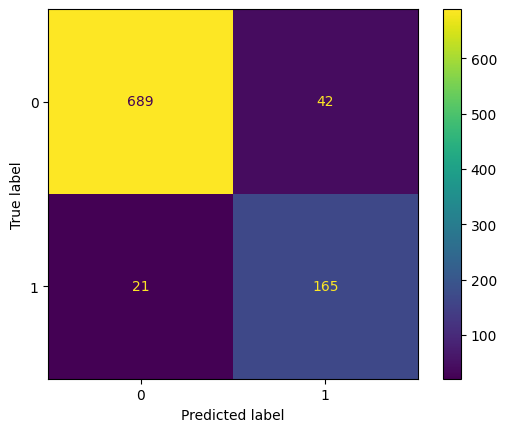

In [79]:
ConfusionMatrixDisplay(
    confusion_matrix(preds, yy_test)
).plot()

In [80]:
print(classification_report(preds, yy_test))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       731
           1       0.80      0.89      0.84       186

    accuracy                           0.93       917
   macro avg       0.88      0.91      0.90       917
weighted avg       0.94      0.93      0.93       917



Term Weigthing improved results without model tunning

## Term Frequency

In [84]:
m_freq = Model(term_freq).fit(xx_train, yy_train)

In [85]:
preds = m_freq.predict(xx_test)

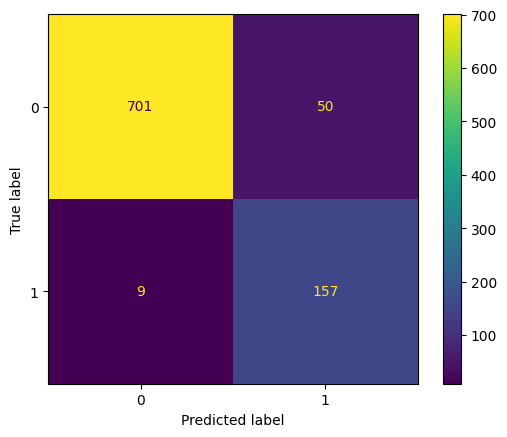

In [86]:
ConfusionMatrixDisplay(
    confusion_matrix(preds, yy_test)
).plot()

In [87]:
print(classification_report(preds, yy_test))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       751
           1       0.76      0.95      0.84       166

    accuracy                           0.94       917
   macro avg       0.87      0.94      0.90       917
weighted avg       0.95      0.94      0.94       917



## Inverse Freq

In [93]:
m_inv_freq = Model2(inv_term_freq).fit(xx_train, yy_train)

In [94]:
preds = m_inv_freq.predict(xx_test)

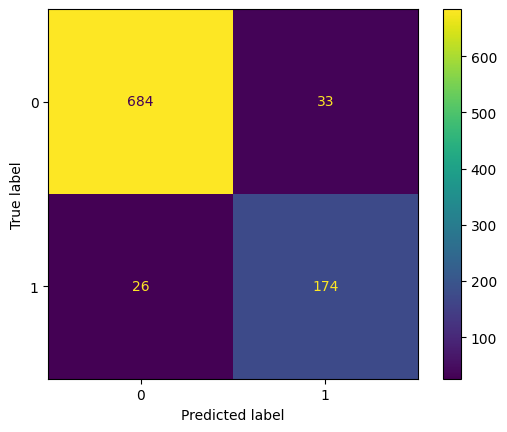

In [95]:
ConfusionMatrixDisplay(
    confusion_matrix(preds, yy_test)
).plot()

In [96]:
print(classification_report(preds, yy_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       717
           1       0.84      0.87      0.86       200

    accuracy                           0.94       917
   macro avg       0.90      0.91      0.91       917
weighted avg       0.94      0.94      0.94       917



## Latent Semantic Analysis

In [5]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from string import punctuation

In [4]:
X_train = train_set.Text
y_train = train_set.Spam
xx_train, xx_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

In [6]:
t1 = lambda arr: np.log2(1+arr)
t2 = lambda arr: np.log2(1 + t1(arr))
t3 = lambda arr, k: (k+1)*arr/(arr+k)

In [73]:
def tf_idf_bag_of_words(
        
        document: str,
        freq,
        vocab,
        t: Callable) -> Sequence:
        
        bow = np.zeros(len(vocab))
        loc = dict(map(lambda pair: (pair[1], pair[0]), enumerate(vocab)))

        for word in Model().filter_tokens(nltk.word_tokenize(document)):
            if word in vocab:
                bow[loc[word.lower()]]+=1

        bow = t(bow)

        for i, v in enumerate(bow):
            if v!=0:
                bow[i] = np.log((freq[i] + 1) / bow[i])
        return bow

In [86]:
def dot_dist(X1, X2):
    return -(X1@X2)

In [87]:
class Model:
    def __init__(self, 
                 estimator = KNeighborsClassifier(metric = dot_dist),
                ):
        self.estimator=estimator
    
    
    def filter_tokens(self, list_of_tokens):
        for token in list_of_tokens:
            if token.lower() not in ENGLISH_STOP_WORDS and token not in punctuation:
                yield token
            
            
    def tf_idf_bag_of_words(
        self,
        document: str, 
        t: Callable) -> Sequence:
        
        bow = np.zeros(len(self.vocab))
        loc = dict(map(lambda pair: (pair[1], pair[0]), enumerate(self.vocab)))

        for word in self.filter_tokens(nltk.word_tokenize(document)):
            if word in self.vocab:
                bow[loc[word.lower()]]+=1

        bow = t(bow)

        for i, v in enumerate(bow):
            if v!=0:
                bow[i] = np.log((self.freq[i] + 1) / bow[i])
        return bow
    
    
    def get_vocabulary_and_frequency(self, all_docs)->set:
        vocab = dict()
        
        for doc in all_docs:
            current_words = dict()
            
            for word in self.filter_tokens(nltk.word_tokenize(doc)):
                try:
                    current_words[word.lower()]
                except:
                    vocab[ word.lower() ] = vocab.get(word.lower(),  0) + 1
                    current_words[ word.lower() ] = 1
                    
        return vocab.keys(), vocab.values()
    
    
    def fit(self, X, y):
        self.vocab, self.freq = self.get_vocabulary_and_frequency(X)
        self.vocab = list(self.vocab); self.freq = list(self.freq)
        
        print("Vocab Generated..")
        
        X = np.array([ self.tf_idf_bag_of_words(x, t1) for x in X ])
        
        print("W computed..")
        
        self.T, self.S, self.D = np.linalg.svd(X.T, full_matrices=False)
        X = (self.D.T @ np.diag(self.S)).T
        
        print("Reduced W computed..")
        
        self.X = X
        self.y = y
        
        print("Fitting Model..")
        self.estimator.fit(X,y)
        return self
    
    def predict(self, X):
        X = np.array([ self.tf_idf_bag_of_words(x, t1) for x in X ])
        X = X @ self.T
        
        return self.estimator.predict(X)

In [80]:
model = Model().fit(xx_train, yy_train)

Vocab Generated..
W computed..
Reduced W computed..
Fitting Model..


In [81]:
preds = model.predict(xx_test)

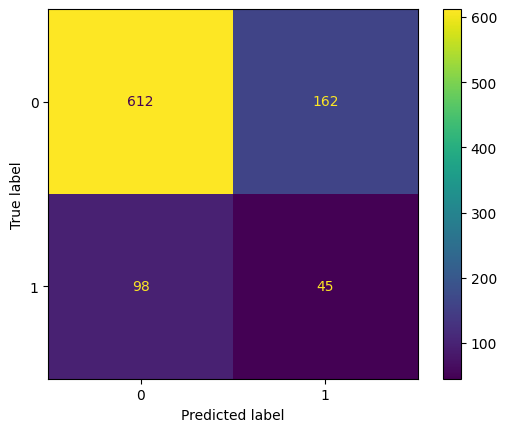

In [83]:
ConfusionMatrixDisplay(
    confusion_matrix(preds, yy_test)
).plot()

In [84]:
print(classification_report(preds, yy_test))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       774
           1       0.22      0.31      0.26       143

    accuracy                           0.72       917
   macro avg       0.54      0.55      0.54       917
weighted avg       0.76      0.72      0.74       917

